In [102]:
try:
  from datasets import load_dataset
except:
  ! pip install datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from pathlib import Path

MODEL_NAME = "distilbert/distilbert-base-uncased"

dataset = load_dataset("AliAfkhamii/hf_emotion_generation_texts")

labels = dataset["train"].unique("label")
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in id2label.items()}


model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
dataset.column_names

{'train': ['text', 'label']}

In [104]:
def labels_to_ids(sample):
    sample['label'] = label2id[sample['label']]
    return sample

dataset = dataset['train'].map(labels_to_ids)

In [105]:
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)

In [106]:
def tokenize_text(sample):
    return tokenizer(sample["text"], truncation=True, padding=True)


dataset = dataset.map(tokenize_text, batched=True, batch_size=1000)

In [107]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 450
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 113
    })
})

In [108]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [109]:
def count_params(model):

    trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    total_params = sum([p.numel() for p in model.parameters()])

    print(f"total parameters: {total_params} | trainable parameters: {trainable_params} | not trainable parameters: {total_params - trainable_params}")

count_params(model)

total parameters: 66957317 | trainable parameters: 66957317 | not trainable parameters: 0


In [110]:
try:
  import evaluate
except:
  ! pip install evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(preds_labels: tuple[np.array, np.array]):

    preds, labels = preds_labels

    if len(preds.shape) >= 2:
        preds = np.argmax(preds, axis=1)

    return accuracy_metric.compute(predictions=preds, references=labels)

In [111]:
model_path = Path("../models")
model_path.mkdir(parents=True, exist_ok=True)

model_save_name = "hf_emotion_detector_text_classifier-distilbert-base-uncased"
model_save_dir = model_path / model_save_name


training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0005,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    load_best_model_at_end=True,
    weight_decay=0.1,
    logging_strategy="epoch",
    report_to="none",
    hub_private_repo=False,
)

training_args

TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [112]:
from transformers import EarlyStoppingCallback
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["test"],
                  processing_class=tokenizer,
                  compute_metrics=compute_accuracy,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
                  )

In [113]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.171200,0.505223,0.831858
2,0.468300,0.313894,0.911504
3,0.203300,0.267255,0.929204
4,0.101400,0.320758,0.902655
5,0.048900,0.318000,0.938053


In [118]:
results

TrainOutput(global_step=75, training_loss=0.39863646268844605, metrics={'train_runtime': 425.8635, 'train_samples_per_second': 6.34, 'train_steps_per_second': 0.211, 'total_flos': 16882734757500.0, 'train_loss': 0.39863646268844605, 'epoch': 5.0})

In [115]:
results

TrainOutput(global_step=75, training_loss=0.39863646268844605, metrics={'train_runtime': 425.8635, 'train_samples_per_second': 6.34, 'train_steps_per_second': 0.211, 'total_flos': 16882734757500.0, 'train_loss': 0.39863646268844605, 'epoch': 5.0})

In [116]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics (we've seen these already)
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 1.1712,
  'grad_norm': 16.273387908935547,
  'learning_rate': 0.0004222222222222222,
  'epoch': 1.0,
  'step': 15},
 {'eval_loss': 0.5052229762077332,
  'eval_accuracy': 0.831858407079646,
  'eval_runtime': 5.3813,
  'eval_samples_per_second': 20.999,
  'eval_steps_per_second': 0.743,
  'epoch': 1.0,
  'step': 15},
 {'loss': 0.4683,
  'grad_norm': 0.3679497539997101,
  'learning_rate': 0.0003388888888888889,
  'epoch': 2.0,
  'step': 30},
 {'eval_loss': 0.3138938546180725,
  'eval_accuracy': 0.911504424778761,
  'eval_runtime': 4.3091,
  'eval_samples_per_second': 26.224,
  'eval_steps_per_second': 0.928,
  'epoch': 2.0,
  'step': 30}]

In [117]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:6])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 16.273387908935547,
  'learning_rate': 0.0004222222222222222,
  'loss': 1.1712,
  'step': 15},
 {'epoch': 2.0,
  'grad_norm': 0.3679497539997101,
  'learning_rate': 0.0003388888888888889,
  'loss': 0.4683,
  'step': 30},
 {'epoch': 3.0,
  'grad_norm': 0.8927147388458252,
  'learning_rate': 0.00025555555555555553,
  'loss': 0.2033,
  'step': 45},
 {'epoch': 4.0,
  'grad_norm': 0.22466963529586792,
  'learning_rate': 0.00017222222222222224,
  'loss': 0.1014,
  'step': 60},
 {'epoch': 5.0,
  'grad_norm': 0.2199181467294693,
  'learning_rate': 8.888888888888889e-05,
  'loss': 0.0489,
  'step': 75}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 0.831858407079646,
  'eval_loss': 0.5052229762077332,
  'eval_runtime': 5.3813,
  'eval_samples_per_second': 20.999,
  'eval_steps_per_second': 0.743,
  'step': 15},
 {'epoch': 2.0,
  'eval_accuracy': 0.911504424778761,
  'eval_loss': 0.313893854618

In [120]:
import pandas as pd

# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,1.1712,16.273388,0.000422,1.0,15
1,0.4683,0.367950,0.000339,2.0,30
2,0.2033,0.892715,0.000256,3.0,45
3,0.1014,0.224670,0.000172,4.0,60
4,0.0489,0.219918,0.000089,5.0,75


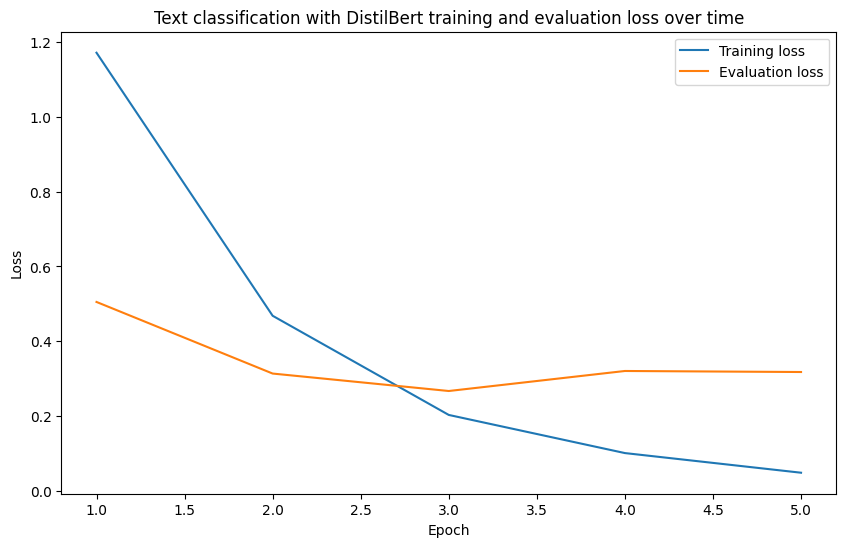

In [121]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

In [125]:
from google.colab import userdata
token = userdata.get('HF_TOKEN')

model = AutoModelForSequenceClassification.from_pretrained("models/hf_emotion_detector_text_classifier-distilbert-base-uncased/checkpoint-45")
trainer.model = model


trainer.push_to_hub(
    commit_message="push best model to hub",
    token=token
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AliAfkhamii/hf_emotion_detector_text_classifier-distilbert-base-uncased/commit/1b94f696576173cdf0aaeebb8b7458c3d0bad4a0', commit_message='push best model to hub', commit_description='', oid='1b94f696576173cdf0aaeebb8b7458c3d0bad4a0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AliAfkhamii/hf_emotion_detector_text_classifier-distilbert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='AliAfkhamii/hf_emotion_detector_text_classifier-distilbert-base-uncased'), pr_revision=None, pr_num=None)

In [128]:
all_predictions = trainer.predict(dataset['test'])
prediction_values = all_predictions.predictions
prediction_values.metrics

{'test_loss': 0.2672548294067383,
 'test_accuracy': 0.9292035398230089,
 'test_runtime': 6.9289,
 'test_samples_per_second': 16.308,
 'test_steps_per_second': 0.577}

In [129]:
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities (this is optional, could get the same results with step 2 onwards)
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = dataset["test"]["label"]

# 4. Compare predicted labels to true labels to get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}%")

[INFO] Test accuracy: 92.92035398230088%


In [142]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.sample(10)

,text,true_label,pred_label,pred_prob
110,I finally learned to swim. I feel so accomplis...,3,3,0.977536
67,I'm fuming! They charged me extra for a servic...,0,0,0.973806
43,I missed the train and now I'll be late for th...,1,1,0.990513
61,I didn't make the team this year. All that pra...,1,1,0.988572
86,I can't believe you forgot about our meeting a...,0,0,0.986290
29,Was cleaning out the attic and found letters f...,4,1,0.982398
31,You're having a baby? Congratulations! I didn'...,4,4,0.975757
40,Your constant negativity is bringing everyone ...,0,0,0.987232
46,I can't believe I won the cooking contest. I d...,4,4,0.954297
62,This restaurant gave us free dessert just beca...,4,3,0.904902


In [143]:
dataset['test'][29]['text']

'Was cleaning out the attic and found letters from my great-grandparents dating back to WWII.'

In [137]:
id2label

{0: 'anger', 1: 'sadness', 2: 'fear', 3: 'joy', 4: 'surprise'}

In [145]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
4,We lost sight of the trail an hour ago and now...,2,2,0.469795
27,I'm at my wits' end. This project has been not...,0,2,0.647471
97,My dog slipped his leash and ran toward the ro...,2,1,0.713740
10,Got an unexpected call from my boss titled 'ur...,2,2,0.721213
107,Got back from the doctor's — officially cancer...,3,1,0.754743
51,I can't believe I got the lead role in the pla...,4,4,0.777262
0,I can't believe I won the lottery! I never tho...,4,4,0.816261
42,I just got a call from the publisher—my book i...,3,3,0.832824
93,Today I realized — I'm genuinely happy with my...,3,3,0.843183
71,Client cancelled the project we spent six mont...,1,1,0.883302


In [146]:
dataset['test'][4]['text']

"We lost sight of the trail an hour ago and now it's getting dark."

In [147]:
dataset['test'][27]['text']

"I'm at my wits' end. This project has been nothing but a nightmare from start to finish."

In [ ]:
!zip -r models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/hf_emotion_detector_text_classifier-distilbert-base-uncased/ (stored 0%)
  adding: content/models/hf_emotion_detector_text_classifier-distilbert-base-uncased/config.json (deflated 49%)
  adding: content/models/hf_emotion_detector_text_classifier-distilbert-base-uncased/checkpoint-75/ (stored 0%)
  adding: content/models/hf_emotion_detector_text_classifier-distilbert-base-uncased/checkpoint-75/config.json (deflated 49%)
  adding: content/models/hf_emotion_detector_text_classifier-distilbert-base-uncased/checkpoint-75/rng_state.pth (deflated 24%)
  adding: content/models/hf_emotion_detector_text_classifier-distilbert-base-uncased/checkpoint-75/optimizer.pt